Now let's go on to our modeling step. As a reminder, our plan of action was as follows:

1. Perform EDA on the dataset to extract valuable insight about the process generating the time series **(COMPLETED)**.
2. Build a baseline model (univariable model without exogenous variables) for benchmarking purposes. **(Covered in this notebook)**
3. Build a univariate model with all exogenous variables to check best possible performance. **(Covered in this notebook)**
4. Evaluate the model with exogenous variables and discuss any potential issues. **(Covered in this notebook)**
5. Overcome issues identified above. **(Covered in this notebook)**
6. Make future predictions with the best model.
7. Replicate flow with Automated Time Series Modeling (AutoML)

In [1]:
# Only enable critical logging (Optional)
import os
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

In [2]:
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret
    what_is_installed()


System:
    python: 3.9.16 (main, Jan 11 2023, 16:16:36) [MSC v.1916 64 bit (AMD64)]
executable: C:\Users\Nikhil\.conda\envs\pycaret_dev_sktime_16p1\python.exe
   machine: Windows-10-10.0.19044-SP0

PyCaret required dependencies:
                 pip: 22.3.1
          setuptools: 65.6.3
             pycaret: 3.0.0rc9
             IPython: 8.10.0
          ipywidgets: 8.0.4
                tqdm: 4.64.1
               numpy: 1.23.5
              pandas: 1.5.3
              jinja2: 3.1.2
               scipy: 1.10.0
              joblib: 1.2.0
             sklearn: 1.2.1
                pyod: 1.0.8
            imblearn: 0.10.1
   category_encoders: 2.6.0
            lightgbm: 3.3.5
               numba: 0.56.4
            requests: 2.28.2
          matplotlib: 3.7.0
          scikitplot: 0.3.7
         yellowbrick: 1.5
              plotly: 5.13.0
             kaleido: 0.2.1
         statsmodels: 0.13.5
              sktime: 0.16.1
               tbats: 1.1.2
            pmdarima: 2.0.2


In [3]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

In [4]:
# Global Figure Settings for notebook ----
# Depending on whether you are using jupyter notebook, jupyter lab, Google Colab, you may have to set the renderer appropriately
# NOTE: Setting to a static renderer here so that the notebook saved size is reduced.
global_fig_settings = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

In [5]:
data = get_data("airquality")

# Limiting the data for demonstration purposes.
data = data.iloc[-720:]
data["index"] = pd.to_datetime(data["Date"] + " " + data["Time"])
data.drop(columns=["Date", "Time"], inplace=True)
data.replace(-200, np.nan, inplace=True)
target = "CO(GT)"

exclude = ['NMHC(GT)', 'AH']
data.drop(columns=exclude, inplace=True)
data.head()

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  2004-03-10  18:00:00     2.6         1360       150      11.9   
1  2004-03-10  19:00:00     2.0         1292       112       9.4   
2  2004-03-10  20:00:00     2.2         1402        88       9.0   
3  2004-03-10  21:00:00     2.2         1376        80       9.2   
4  2004-03-10  22:00:00     1.6         1272        51       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   
3            948      172          1092      122          1584         1203   
4            836      131          1205      116          1490         1110   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7867  
4  11.2  59.6  0.7888

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  \
8637     1.5        983.0       5.9          806.0    180.0         820.0   
8638     1.8       1018.0       7.3          868.0    255.0         751.0   
8639     2.0       1101.0       8.4          916.0    251.0         721.0   
8640     1.9       1116.0       7.7          888.0    258.0         695.0   
8641     2.5       1161.0       9.1          945.0    344.0         654.0   

      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH               index  
8637    132.0         966.0        615.0  13.5  28.3 2005-03-05 15:00:00  
8638    162.0        1015.0        804.0  13.0  29.7 2005-03-05 16:00:00  
8639    159.0        1125.0        861.0  11.6  38.7 2005-03-05 17:00:00  
8640    156.0        1176.0        980.0   8.6  56.3 2005-03-05 18:00:00  
8641    177.0        1205.0       1077.0   8.5  57.9 2005-03-05 19:00:00

# Step 2: Baseline Model - Univariate forecasting without exogenous variables

In [6]:
data_uni = data.copy()
data_uni.set_index("index", inplace=True)
data_uni = data_uni[target]

exp_uni = TSForecastingExperiment()
exp_uni.setup(
    data=data_uni, fh=48,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=42
)

In [7]:
model = exp_uni.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,24))

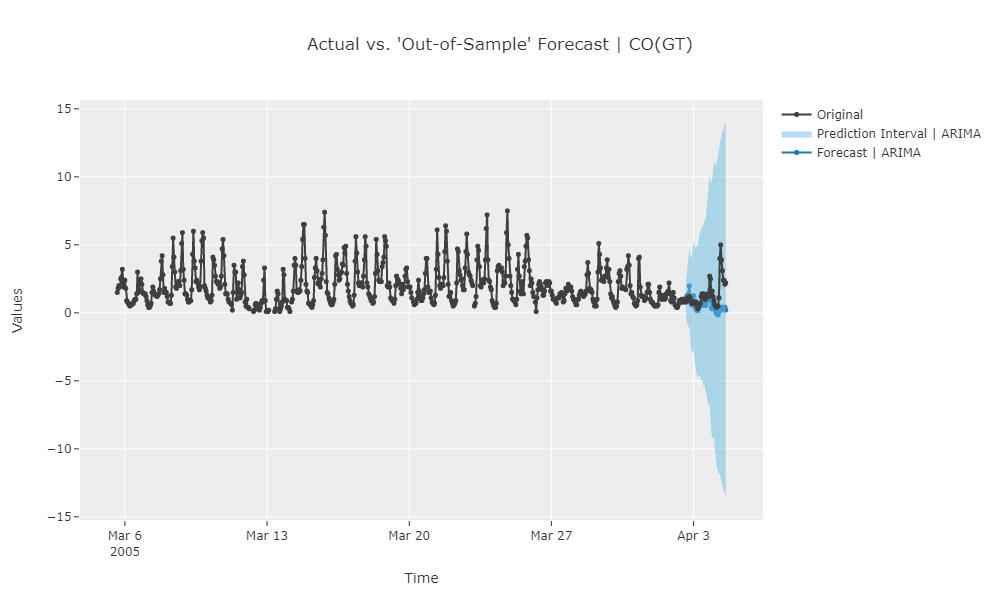

In [8]:
exp_uni.plot_model(model)

On zooming in to the forecasts, we can see that the model is able to capture some of the trends (spikes) in the dataset, but not all. The performance of our baseline model indicates that mean MASE across the CV folds is 1.52 which is not that great. Any value > 1 indicates that the model is performing worse than even a naive model with one step ahead forecasts. This model needs more improvement. Let's see if adding exogenous variables can help improve the model performance.

# Step 3: Improved Model - Univariate forecasting with exogenous variables

In [9]:
exp_exo = TSForecastingExperiment()
exp_exo.setup(
    data=data, target=target, index="index", fh=48,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=42
)

In [10]:
model_exo = exp_exo.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,24))

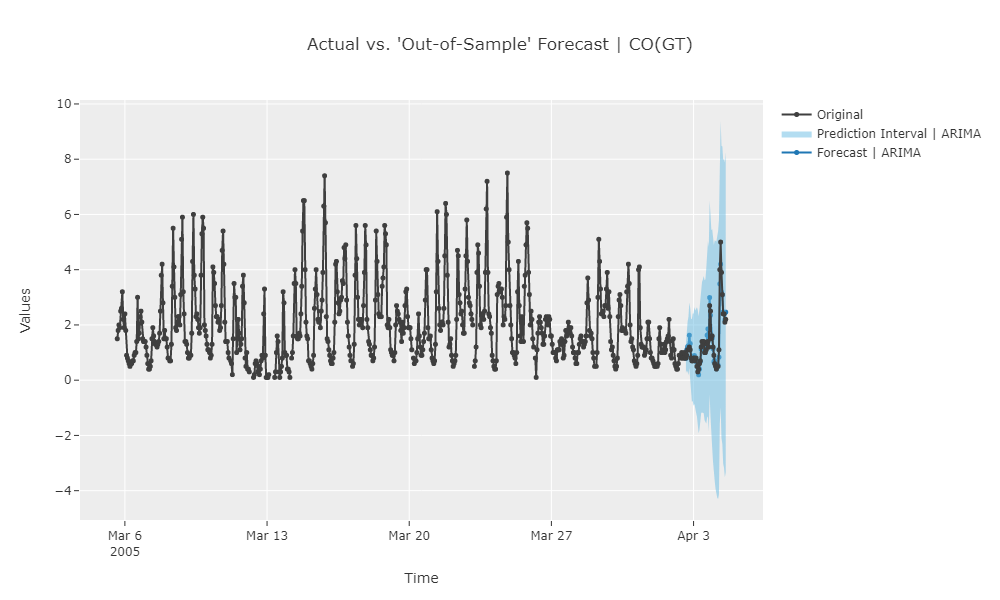

In [11]:
exp_exo.plot_model(model_exo)

# Step 4: Evaluate Model

Not bad, We have managed to improve MASE significantly which is much better than the univariate model and also a large improvement over a naive model. We should be happy with this improvement. Let's finalize the model by training it on the entire dataset so we can make true future forecasts.

In [12]:
final_model_exo = exp_exo.finalize_model(model_exo)

In [13]:
def safe_predict(exp, model):
    """Prediction wrapper for demo purposes."""
    try: 
        exp.predict_model(model)
    except ValueError as exception:
        print(exception)
        exo_vars = exp.exogenous_variables
        print(f"{len(exo_vars)} exogenous variables (X) needed in order to make future predictions:\n{exo_vars}")

safe_predict(exp_exo, final_model_exo)

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
10 exogenous variables (X) needed in order to make future predictions:
['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH']


As we can see, this approach does not come without side effects. The problem is that we have 10 exogenous variables. Hence in order to get any unknown future values for CO concentration, we will need the future values for all these exogenous variables. This is generally obtained through some forecasting process itself. But each forecast will have errors and these errors can be compounded when there are a lot of exogenous variables. 

**Let's see if we can trim down these exogenous variables to a handful of useful variables without compromising on forecasting performance.**

# Step 5: Parsimonious Model - Univariate forecasting with limited exogenous variables

From the CCF Analysis, we found that many of the exogenous variables show a very similar correlation structure to the CO concentration. E.g. `PT08.S1(CO)`, `NOx(GT)`, `C6H6(GT)`, `PT08.S2(NMHC)` values from 24 hours before (lag = 24) show a high positive correlation to CO concentration. Instead of keeping all of them, lets pick the one with the highest positive correlation at lag 24 which is `NOx(GT)`.

Similarly, `PT08.S3(NOx)` values from 24 hours ago shows the highest negative correlation to CO concentration. Let's keep this variable as well.

Finally, in daily cycles, what happens 12 hours back can also impact the current value (e.g. values last night can impact the next day and vice versa). The variable with the highest correlation to CO concentration at lag = 12 is `RH`. We will keep this as well.

In [14]:
exp_slim = TSForecastingExperiment()
keep = [target, "index", 'NOx(GT)', "PT08.S3(NOx)", "RH"]
data_slim = data[keep]
exp_slim.setup(
    data=data_slim, target=target, index="index", fh=48,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=42 
)

In [15]:
model_slim = exp_slim.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,24))

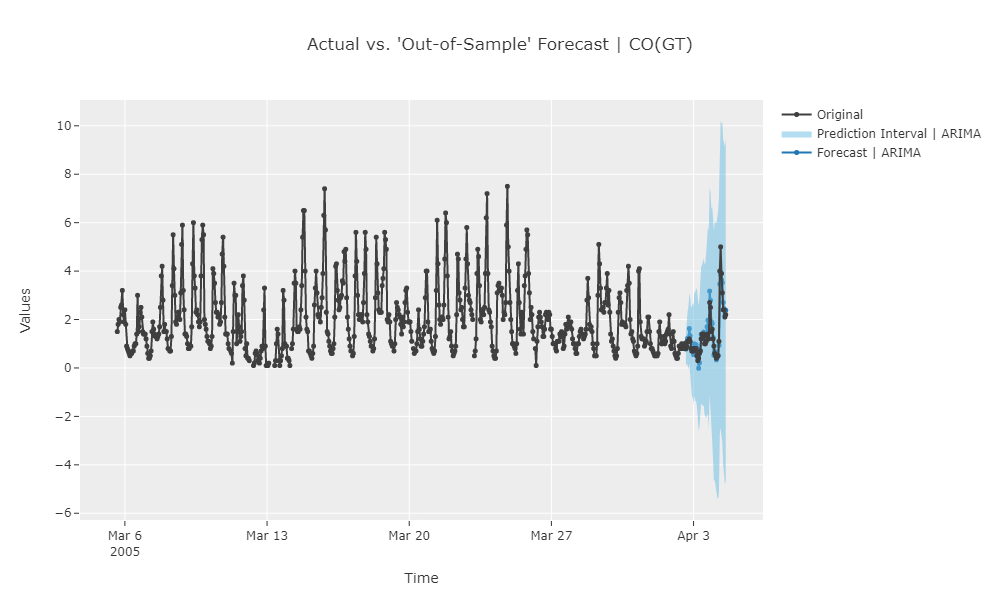

In [16]:
exp_slim.plot_model(model_slim)

Not bad. MASE has only increased slightly, but we have managed to cut our exogenous variables significantly. This will help us when we make "true" unknown future predictions since we will need the "unknown" future values of these exogenous variables to make the forecast for the CO concentration.

# Finalize the model

- Train the slim model on the entire dataset so we can make true future forecasts
- Save the model as a pickle file for deployment 

In [17]:
final_slim_model = exp_slim.finalize_model(model_slim)

In [18]:
_ = exp_slim.save_model(final_slim_model, "final_slim_model")

Transformation Pipeline and Model Successfully Saved


In [19]:
safe_predict(exp_slim, final_slim_model)

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
3 exogenous variables (X) needed in order to make future predictions:
['NOx(GT)', 'PT08.S3(NOx)', 'RH']


**So we still need future values for 3 exogenous variables. We will get this in the next part using forecasting techniques.**

### The next steps would typically be done in a new session/notebook

Now that we have build our model, let's make future predictions. As a reminder, our plan of action was as follows:

1. Perform EDA on the dataset to extract valuable insight about the process generating the time series **(COMPLETED)**.
2. Build a baseline model (univariable model without exogenous variables) for benchmarking purposes **(COMPLETED)**.
3. Build a univariate model with all exogenous variables to check best possible performance **(COMPLETED)**.
4. Evaluate the model with exogenous variables and discuss any potential issues **(COMPLETED)**.
5. Overcome issues identified above **(COMPLETED)**.
6. Make future predictions with the best model. **(Covered in this notebook)**
7. Replicate flow with Automated Time Series Modeling (AutoML)

In [20]:
exog_vars = ['NOx(GT)', 'PT08.S3(NOx)', 'RH']
data = data[exog_vars]
data.head()

NOx(GT)  PT08.S3(NOx)    RH
8637    180.0         820.0  28.3
8638    255.0         751.0  29.7
8639    251.0         721.0  38.7
8640    258.0         695.0  56.3
8641    344.0         654.0  57.9

# Step 6: Making Future Predictions

# Step 6A: Get future exogenous variable values using forecasting

In [21]:
exog_exps = []
exog_models = []
for exog_var in exog_vars:
    exog_exp = TSForecastingExperiment()
    exog_exp.setup(
        data=data[exog_var], fh=48,
        numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
        fig_kwargs=global_fig_settings, session_id=42
    )

    # Users can customize how to model future exogenous variables i.e. add
    # more steps and models to potentially get better models at the expense
    # of higher modeling time.
    best = exog_exp.compare_models(
        sort="mase", include=["arima", "ets", "exp_smooth", "theta", "lightgbm_cds_dt",]        
    )
    final_exog_model = exog_exp.finalize_model(best)

    exog_exps.append(exog_exp)
    exog_models.append(final_exog_model)

# Step 2: Get future predictions for exog variables ----
future_exog = [
    exog_exp.predict_model(exog_model)
    for exog_exp, exog_model in zip(exog_exps, exog_models)
]
future_exog = pd.concat(future_exog, axis=1)
future_exog.columns = exog_vars

In [22]:
future_exog

NOx(GT)  PT08.S3(NOx)       RH
9357  247.2036      651.1830  13.0838
9358  274.0699      644.2770  13.1056
9359  298.6685      613.3309  13.0876
9360  231.8742      558.1970  13.1094
9361  398.1459      499.6994  13.0913
9362  378.3662      524.6385  13.1131
9363  252.7246      596.2236  13.0950
9364  246.6336      684.6523  13.1169
9365  180.6670      721.4174  13.0988
9366  125.5157      756.1241  13.1206
9367   76.9556      832.2936  13.1025
9368   74.8243      889.7899  13.1244
9369   67.0040      960.8931  13.1063
9370   56.4091     1017.3089  13.1281
9371   80.9777     1023.5586  13.1100
9372  185.6649      969.1069  13.1318
9373  597.4380      824.1328  13.1138
9374  589.2735      721.3926  13.1356
9375  526.1542      666.4044  13.1175
9376  475.0677      706.3715  13.1393
9377  356.0050      747.2181  13.1212
9378  295.9595      774.7065  13.1431
9379  237.9265      799.2786  13.1250
9380  267.9026      800.7291  13.1468
9381  250.0888      793.4989  13.1287
9382  276.9426      783.8131  13.1506
9383  301.5320      744.9767  13.1325
9384  234.7311      676.9468  13.1543
9385  400.9980      605.0705  13.1362
9386  381.2148      634.3049  13.1581
9387  255.5708      719.7775  13.1399
9388  249.4779      825.3166  13.1618
9389  183.5099      868.3771  13.1437
9390  128.3577      908.8575  13.1656
9391   79.7969      999.0097  13.1474
9392   77.6651     1066.5478  13.1693
9393   69.8444     1150.2087  13.1512
9394   59.2492     1216.1076  13.1731
9395   83.8177     1221.9631  13.1549
9396  188.5047     1155.4515  13.1768
9397  600.2777      981.3416  13.1586
9398  592.1131      857.9179  13.1806
9399  528.9938      791.5363  13.1624
9400  477.9073      837.9784  13.1843
9401  358.8445      885.3629  13.1661
9402  298.7990      916.8384  13.1880
9403  240.7660      944.8063  13.1699
9404  270.7421      945.4231  13.1918

# Step 6B: Load Model and make future predcitons for the target variable

In [23]:
exp_future = TSForecastingExperiment()

In [24]:
final_slim_model = exp_future.load_model("final_slim_model")

Transformation Pipeline and Model Successfully Loaded


<Axes: >

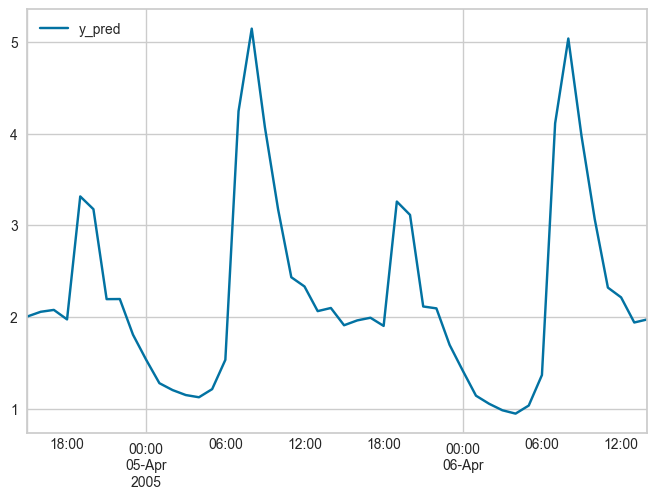

In [25]:
future_preds = exp_future.predict_model(final_slim_model, X=future_exog)
future_preds.plot()